## Imports

In [1]:
# imports
import torch
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import wandb
#from prettytable import PrettyTable
import random
import os
from datetime import datetime
from torch.optim import lr_scheduler

# local imports
from models_parameters import losses
from models_parameters import models
from utils import helper_functions_srcnn2 as helper_functions
from utils.dataloader import Dataset as dataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

C:\Users\accou\anaconda3\envs\geo_env3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0


# GENERAL SETTINGS

In [2]:
# Running where? "colab" or "ubs"
location = "local"

# chose which tile to train, test on eg "T30UXU"(9k) or "T30UUU"(3k)
sen2_tile_train = "all"
sen2_tile_val   = "all"
sen2_tile_test  = "all"

# chose dataloader transform - 'standardize', 'histogram_matching', 'moment_matching', 'interpolate' or 'spot6'
transform = "interpolate"

# chose where and how often to output - 'show' or output path 
# /share/projects/erasmus/sesure/working_dir/images/
output_location = "C:\\Users\\accou\\Documents\\thesis\\images\\images_SRCNN_sat\\"

# selesct wether to load from checkpoint - 'None' for no checkpoint or checkpoint path
load_checkpoint = "None"

# Save checkpoints, 'None' to not save, otherwise path
save_checkpoint = True

# set WandB Project Name
model_name = "SRCNN_local_sat_"

In [3]:
# create run_name
run_name = model_name+"_"+transform+"_"+sen2_tile_train+"__"+str(datetime.now().strftime("%d-%m-%Y_%H-%M-%S"))
print(run_name)

SRCNN_local_sat__interpolate_all__22-05-2022_16-41-29


# MODEL SETTINGS

In [4]:
# Load Model, wither straight definitions or loaded models
#model = models.RCAN.create_model(args)
model = models.SRCNN()

# load pretrained model weights
if load_checkpoint!="None":
  model.load_state_dict(torch.load(load_checkpoint))

# Load Loss Function
loss_func = losses.loss_mae


#def loss_func(a,b):
#    p1 = losses.loss_lpips(a,b)
#    p2 = losses.loss_mae(a,b)
#    return((p1*0.001)+p2)


# enable benchmark for faster execution (only if inputs dont change)
torch.backends.cudnn.benchmark = True 

In [5]:
# TRANING SETTINGS
batch_size = 8
lr = 1e-6
epochs = 100
plot_frequency = 50 # in batches

## Create Dataset Object

In [6]:
if location=="colab":
  working_directory = "/content/drive/MyDrive/thesis/"
  folder_path = "/content/drive/MyDrive/thesis/data/"
  dataset_file = "/content/drive/MyDrive/thesis/data/images_subfolders3.pkl"
if location=="ubs":
  working_directory = "/share/projects/erasmus/sesure/working_dir/"
  folder_path = "/share/projects/erasmus/sesure/working_dir/"
  dataset_file = "/share/projects/erasmus/sesure/working_dir/df_saved_images.pkl"
if location=="local":
  working_directory = "C:\\Users\\accou\\Documents\\thesis"
  folder_path = "C:\\Users\\accou\\Documents\\thesis\\data_v2\\"
  dataset_file = "C:\\Users\\accou\\Documents\\thesis\\data_v2\\final_dataset.pkl"

# get dataset object
dataset_train = dataset(folder_path,dataset_file,transform="interpolate",sen2_amount=1, sen2_tile = sen2_tile_train, location=location)
dataset_val   = dataset(folder_path,dataset_file,transform="interpolate",sen2_amount=1, sen2_tile = sen2_tile_val,   location=location)
#dataset_test  = dataset(folder_path,dataset_file,transform,sen2_amount=1, sen2_tile = sen2_tile_test,  location=location)

## Train function

In [7]:
def convert_ycbcr_to_rgb(img):
    if type(img) == np.ndarray:
        r = 298.082 * img[:, :, 0] / 256. + 408.583 * img[:, :, 2] / 256. - 222.921
        g = 298.082 * img[:, :, 0] / 256. - 100.291 * img[:, :, 1] / 256. - 208.120 * img[:, :, 2] / 256. + 135.576
        b = 298.082 * img[:, :, 0] / 256. + 516.412 * img[:, :, 1] / 256. - 276.836
        return np.array([r, g, b]).transpose([1, 2, 0])
    elif type(img) == torch.Tensor:
        img = img*255.0
        if len(img.shape) == 4:
            img = img[0]
        r = 298.082 * img[0, :, :] / 256. + 408.583 * img[2, :, :] / 256. - 222.921
        g = 298.082 * img[0, :, :] / 256. - 100.291 * img[1, :, :] / 256. - 208.120 * img[2, :, :] / 256. + 135.576
        b = 298.082 * img[0, :, :] / 256. + 516.412 * img[1, :, :] / 256. - 276.836
        return torch.stack([r, g, b], 0).unsqueeze(0)/255#.permute(0, 1, 2)
    else:
        raise Exception('Unknown Type', type(img))

In [8]:
def test(generator,test_loader,amount=10):
    import utils.losses as losses
    # keep track of error metrics
    ssim_ls  = []
    psnr_ls  = []
    lpips_ls = []
    mae_ls = []
    ssim_int_ls  = []
    psnr_int_ls  = []
    lpips_int_ls = []
    mae_int_ls = []
    
    # perform 10 predictions, append results to list
    for i in range(0,amount):
        lr,hr = next(iter(test_loader))
        lr,hr = lr.to(device),hr.to(device)
        sr = generator(lr)
        l = losses.calculate_metrics(hr,lr,sr)
        
        
        lpips_ls.append(l[0])
        psnr_ls.append(l[1])
        ssim_ls.append(l[2])
        mae_ls.append(l[3])
        #lpips_int_ls.append(l[4])
        #psnr_int_ls.append(l[5])
        #ssim_int_ls.append(l[6])
        #mae_int_ls.append(l[6])
    
    def Average(lst):
        return sum(lst) / len(lst)
    
    ssim_avg  = round(Average(ssim_ls),5)
    psnr_avg  = round(Average(psnr_ls),5)
    lpips_avg = round(Average(lpips_ls),5)
    mae_avg = round(Average(mae_ls),5)
    #ssim_int_avg  = round(Average(ssim_int_ls),5)
    #psnr_int_avg  = round(Average(psnr_int_ls),5)
    #lpips_int_avg = round(Average(lpips_int_ls),5)
    #mae_int_avg = round(Average(mae_int_ls),5)
    
    wandb.log({'val_psnr': psnr_avg,
               'val_ssim': ssim_avg,
               'val_lpips': lpips_avg,
               'val_mae': mae_avg})

In [9]:
# implementation of model trainer function
def train_model(run_name,model,batch_size=1,lr=0.001,epochs=10,wandb_name="test",plot_frequency=10):
    
    logging=True          # log to WandB
    logging_val=True      # log validation loss in paralel to training loss
    plotting=True         # set if images should be plotted
    plot_frequency = plot_frequency    # set after how many batches images shoud be plotted

    if logging==True:
        wandb.init(name=run_name,project=wandb_name, entity="simon-donike")
        wandb.config = {
          "learning_rate": lr,
          "epochs": epochs,
          "batch_size": batch_size
        }
    
    # define loaders
    
    loader_train = DataLoader(dataset_train,batch_size=batch_size, shuffle=True, num_workers=0,pin_memory=True)
    loader_val  = DataLoader(dataset_val,batch_size=1, shuffle=True, num_workers=0)
    print("dataloader instanciated!")
    print("Len. Train: ",len(loader_train),"(Batch Sz. "+str(batch_size),") Len. Val: ",len(dataset_val),"(Batch Sz. "+str(1)+")")
    """
    from utils.dataloader_urban_interpolate import Dataset
    dataset_train = Dataset()
    loader_train = DataLoader(dataset_train,batch_size=batch_size,shuffle="true")
    loader_val = DataLoader(dataset_train,batch_size=batch_size,shuffle="true")
    print("len train loader: ",len(loader_train))
    """
    train_loss = []  # where we keep track of the training loss
    train_accuracy = []  # where we keep track of the training accuracy of the model
    val_loss = []  # where we keep track of the validation loss
    val_accuracy = []  # where we keep track of the validation accuracy of the model
    epochs = epochs  # number of epochs

    # initialize model
    model.to(device)
    optimizer = optim.Adam([
        {'params': model.conv1.parameters()},
        {'params': model.conv2.parameters()},
        {'params': model.conv3.parameters(), 'lr': lr*0.1}
    ], lr=lr)
    scheduler = lr_scheduler.StepLR(optimizer, 1, 0.1,verbose=True)
    #optimizer = optim.Adam(model.parameters())
    
    for e in range(epochs):
        model.train()
        #train_correct = 0
        batch_count=0
        for (x_train_batch, y_train_batch) in loader_train:
            batch_count = batch_count+1
            
            # send data to device
            x_train_batch = x_train_batch.to(device)
            y_train_batch = y_train_batch.to(device) # to float

            # forward pass
            y_hat = model(x_train_batch)  
            # compute the loss
            loss = loss_func(y_hat, y_train_batch)  

            loss.backward()  # obtain the gradients with respect to the loss
            optimizer.step()  # perform one step of gradient descent
            optimizer.zero_grad()  # reset the gradients to 0

            """ START LOGGING & PLOTTING """
            # Log train loss if not logging train+val loss
            if logging==True:
                wandb.log({'loss_train_step': loss.item() / len(x_train_batch)})
            # log val loss together with train and val loss
            if logging_val and logging:
              model.eval()
              x_val_batch, y_val_batch = next(iter(loader_val))
              x_val_batch = x_val_batch.to(torch.float).to(device)
              y_val_batch = y_val_batch.to(torch.float).to(device)
              y_hat_val = model(x_val_batch)
              loss_val = loss_func(y_hat_val, y_val_batch) 
              wandb.log({'loss_val_step': loss_val.item() / len(y_val_batch)})
              del x_val_batch
              del y_val_batch
              model.train()
                
            
            # bring back to RGB space
            y_train_batch = convert_ycbcr_to_rgb(y_train_batch)
            y_hat = convert_ycbcr_to_rgb(y_hat)
            x_train_batch = convert_ycbcr_to_rgb(x_train_batch)
            

            # log and plot after each batch/after plotting frequency
            if plotting==True:
                if batch_count%plot_frequency==0:
                    print('Epoch', e, ' Batch',batch_count,' finished.  No. of trained Images: '+str(batch_count*batch_size))
                    psnr_int = round(losses.loss_psnr(y_train_batch,helper_functions.interpolate_tensor(y_hat)).item(),2)
                    psnr_pred = round(losses.loss_psnr(y_train_batch,y_hat).item(),2)
                    print(psnr_pred)
                    
                    helper_functions.plot_tensors_window(y_train_batch,x_train_batch,y_hat,fig_path=output_location)
                    print("Tensor Mean:",round(y_hat.mean().item(),6),"Max: ",round(y_hat.max().item(),6),"Min: ",round(y_hat.min().item(),6))
                    
                    # log metrics t WandB
                    test(model,loader_train)



        """ END OF EPOCH, logging and plotting """
        print ('Epoch', e+1, ' training finished.')
        scheduler.step()
        
        if save_checkpoint:
          torch.save(model.state_dict(), working_directory+"/checkpoints/"+run_name+".pkl")
        """
        PERFORM VALIDATION STEP after each epoch
        """
        model.eval()
        # perform inference 10 times on random images
        psnr_inter_list = []
        psnr_pred_list = []
        loss_val_list = []
        for i in range(5):
          # Load val Data and to device
          x_val_batch, y_val_batch = next(iter(loader_val))
          x_val_batch = x_val_batch.to(torch.float).to(device)
          y_val_batch = y_val_batch.to(torch.float).to(device)
        
          # perform inference step
          with torch.no_grad():
            pred = model(x_val_batch)

          # calculate metrics
          val_loss = loss_func(pred, y_val_batch).item()
          psnr_int = round(losses.loss_psnr(y_val_batch,helper_functions.interpolate_tensor(x_val_batch)).item(),2)
          psnr_pred = round(losses.loss_psnr(y_val_batch,pred).item(),2)
          psnr_inter_list.append(psnr_int)
          psnr_pred_list.append(psnr_pred)
          loss_val_list.append(val_loss)
        
        # TODO: implement SSIM
        print("VALIDATION: Visualizing 1 of 10 inference steps. Values are averages. Time: ",datetime.now().strftime("%d-%m-%Y %H:%M:%S"))
        psnr_int_avg = round(sum(psnr_inter_list) / len(psnr_inter_list),2)
        psnr_pred_avg = round(sum(psnr_pred_list) / len(psnr_pred_list),2)
        loss_val_avg = round(sum(loss_val_list) / len(loss_val_list),2)
        helper_functions.plot_tensors_window(y_val_batch,x_val_batch,pred,psnr_int_avg,psnr_pred_avg,fig_path=output_location)
        # return model to train state
        model.train()

        # log validation accuracy after each epoch
        if logging==True:
            # log val loss
            wandb.log({'val_loss_epoch': loss_val_avg})
            # log val PSNR
            wandb.log({'val_PSNR_epoch': psnr_pred_avg,
                       'epoch':e,
                       'lr':scheduler.get_lr()[0]})

    # Steps to perform after training is finished
    print("Training finished!")
    if logging==True:
        wandb.finish()

# Perform Training

wandb: Currently logged in as: simon-donike (use `wandb login --relogin` to force relogin)


dataloader instanciated!
Len. Train:  5542 (Batch Sz. 8 ) Len. Val:  44335 (Batch Sz. 1)
Adjusting learning rate of group 0 to 1.0000e-06.
Adjusting learning rate of group 1 to 1.0000e-06.
Adjusting learning rate of group 2 to 1.0000e-07.
Epoch 0  Batch 50  finished.  No. of trained Images: 400
1.12


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: -0.535535 Max:  0.506267 Min:  -1.2247
Epoch 0  Batch 100  finished.  No. of trained Images: 800
1.99


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: -0.454694 Max:  0.504188 Min:  -1.153398
Epoch 0  Batch 150  finished.  No. of trained Images: 1200
3.26


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: -0.371743 Max:  0.510158 Min:  -1.094876


KeyboardInterrupt: 

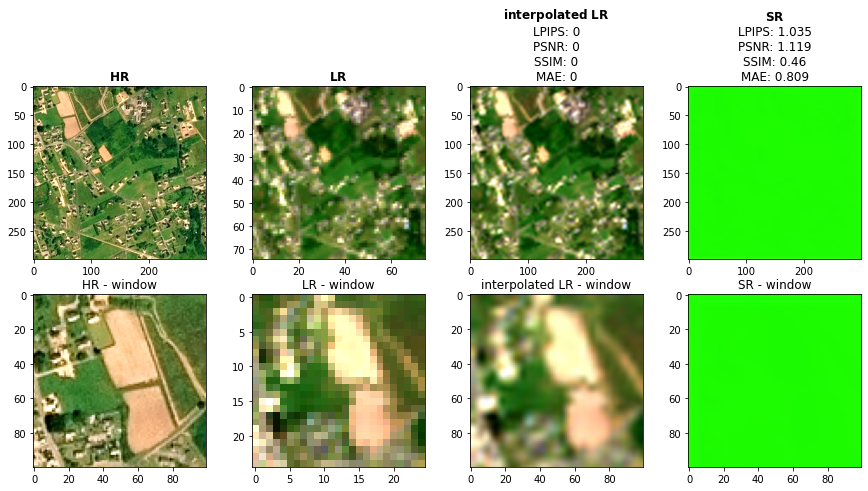

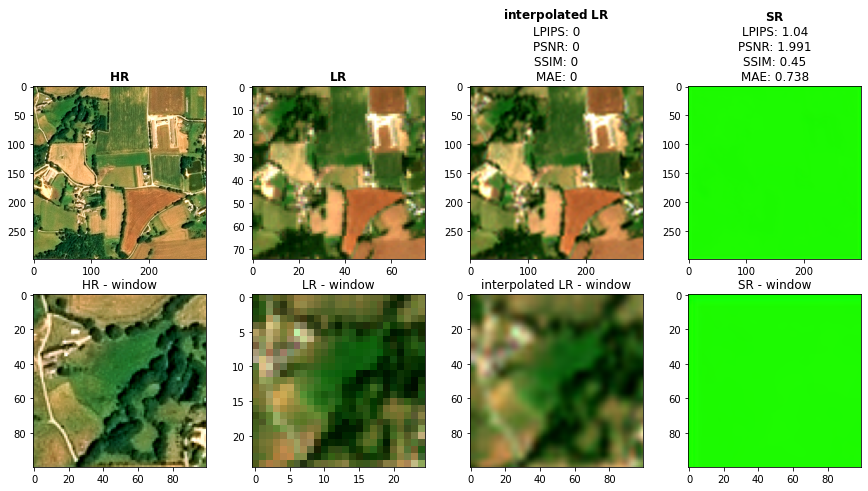

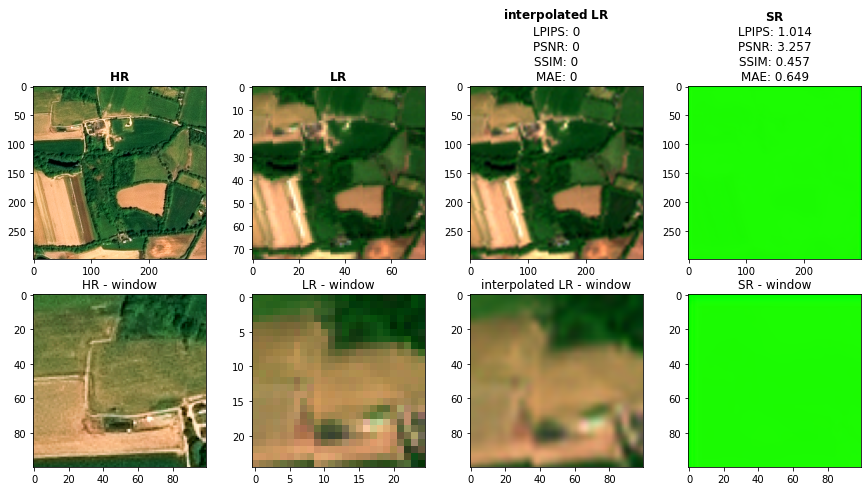

In [10]:
train_model(run_name,model=model,batch_size=batch_size,lr=lr,epochs=epochs,wandb_name=model_name,plot_frequency=plot_frequency)